## Grover’s Algorithm

Andrew Logue

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# import basic plot tools
from qiskit.visualization import plot_histogram

In [8]:
# via IBM Quantum Learning

def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add X-gate to each qubit in zero_inds
        for qubit in zero_inds:
            qc.x(qubit)
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        # Add X-gate to each qubit in zero_inds again to restore the qubits to their original state
        for qubit in zero_inds:
            qc.x(qubit)
    return qc

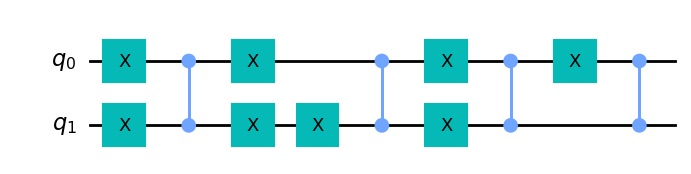

In [9]:
# Implement Grover’s algorithm for each of the possible two-qubit marked strings
marked_states = ["00", "01", "10", "11"]

grover_oracle = grover_oracle(marked_states)
grover_oracle.draw(output="mpl")

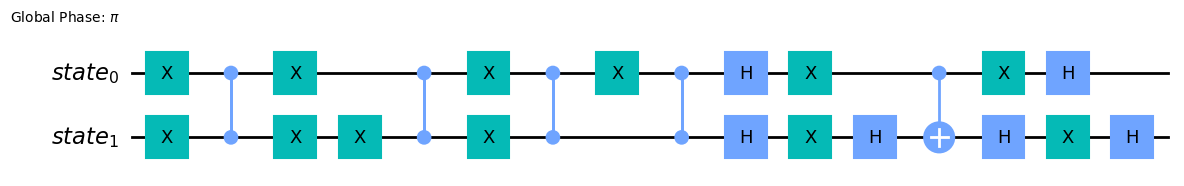

In [10]:
grover_operator = GroverOperator(grover_oracle)
grover_operator.decompose().draw(output="mpl")

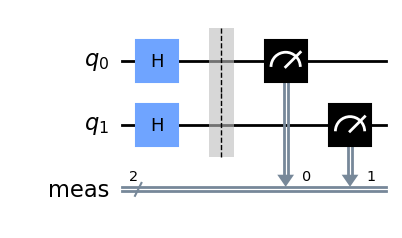

In [11]:
grover_circuit = QuantumCircuit(grover_operator.num_qubits)
# Create even superposition of all basis states
grover_circuit.h(range(grover_operator.num_qubits))
# Apply Grover operator the optimal number of times
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_operator.num_qubits)))
)
grover_circuit.compose(grover_operator.power(optimal_num_iterations), inplace=True)
# Measure all qubits
grover_circuit.measure_all()
grover_circuit.draw(output="mpl")

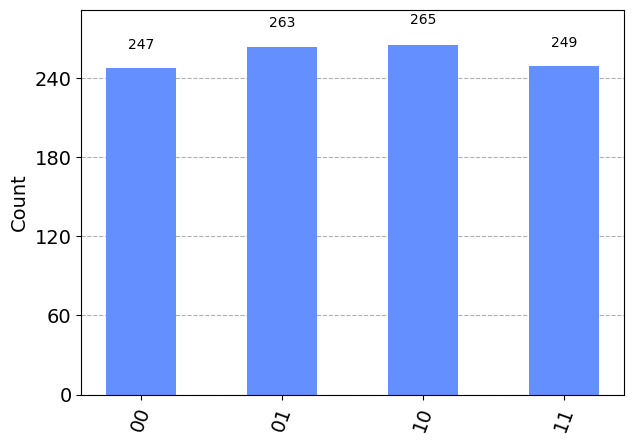

In [12]:
# The result could be reported as a histogram of outcomes (more realistic) 
# and/or as a final state-vector from Qiskit’s state-vector simulator
   
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
Shots = 1024
qc_compiled = transpile(grover_circuit, aer_sim)
job = aer_sim.run(qc_compiled, shots=Shots)
result = job.result()
answer = result.get_counts(qc_compiled)

plot_histogram(answer)